In [1]:
import os
import torch
from torch.nn import *
import torchvision
from torch.optim import Adam, SGD
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN
import torchvision.models.detection.mask_rcnn as mask_rcnn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchsummary import summary
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import math

In [2]:
%%capture
! pip install --upgrade albumentations
!pip install pkbar

In [3]:
import  albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import pkbar

In [4]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path= '/content/drive/MyDrive/Glaucoma detection/Ash'
if os.getcwd() is not path:
  os.chdir(path)
  
print(os.getcwd())

/content/drive/.shortcut-targets-by-id/1G70gvZGG4TOAPNicnudeEnOo6OrbPxfr/DR Classification/Ash


In [6]:
from dataset import *
from model_utils import *

In [7]:
csv_path= 'Master Dataset/Directory.csv'
dataset_path= 'Master Dataset'
batch_size=2
num_epochs=20
device="cuda" if torch.cuda.is_available() else "cpu"
learning_rate=3e-4
dir='weights'
check_pt_file=os.path.join(dir, 'RedRCNN_t3_1.pth.tar')

In [8]:
transforms = A.Compose(
    [
     A.CLAHE(p=1),
     A.HorizontalFlip(p=0.5),
     A.RandomRotate90(p=0.5), 
     A.RandomGamma(p=0.8),
     ToTensorV2()], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bbox_classes']))

In [9]:
dataset= Red_RCNN_Dataset(main_dir=dataset_path, img_shape=(512, 512), csv_file_path=csv_path, transforms= transforms)
print(f"Dataset size= {dataset.__len__()} images")
generator=torch.Generator().manual_seed(42)

train_dataset, dum_set= random_split(dataset, [1+int(0.6*dataset.__len__()), int(0.4*dataset.__len__())], generator=generator)
val_dataset, test_dataset= random_split(dataset, [1+int(0.5*dataset.__len__()), int(0.5*dataset.__len__())], generator=generator)
train_loader= DataLoader(train_dataset, batch_size=batch_size, shuffle= True, drop_last=True)
val_loader= DataLoader(val_dataset, batch_size=batch_size, drop_last=True)
test_loader= DataLoader(test_dataset, batch_size=8)

Dataset size= 1301 images


In [10]:
# images, targets= next(iter(test_loader))

# def visualize(image, boxes, class_names):
#     img = image.copy()
#     for box, class_name in zip(boxes, class_names):
#       img = visualize_bbox(img, np.array(box), class_name)
#     return img

# for i in range(batch_size):
#   fig = plt.figure(figsize=(60,60))

#   img = images[i].permute(1,2,0).numpy()
#   t_boxes = targets['boxes'][i]
#   t_masks = targets['masks'][i].permute(1,2,0).numpy()
  
#   img_bb = visualize(img, t_boxes, ['Cup','Disc'])
    
#   ax1 = fig.add_subplot(1,4,1)
#   ax1.imshow(img)

#   ax2 = fig.add_subplot(1,4,2)
#   ax2.imshow(img_bb)

#   ax3 = fig.add_subplot(1,4,3)
#   ax3.imshow(t_masks[:,:,0], 'gray')

#   ax4 = fig.add_subplot(1,4,4)
#   ax4.imshow(t_masks[:,:,1], 'gray')

#   plt.show()

In [11]:
model= RED_RCNN(num_classes=3, connection_type='t3').to(device=device)
optimizer= SGD(model.parameters(), lr=learning_rate, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9, verbose=False)

In [12]:
train_per_epoch = len(train_loader)
val_per_epoch = len(val_loader)
min_loss = math.inf
loss_types = ['loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'iou']
a = 0.7
for epoch in range(num_epochs):
  train_params = {i: [] for i in loss_types}
  model.train()
  kbar_train = pkbar.Kbar(target = train_per_epoch, epoch = epoch, num_epochs = num_epochs)
  for batch_idx, (images, targets) in enumerate(train_loader):
    images, targets = process_data(images, targets, batch_size, device)

    loss_dict = model(images, targets, mode = 'train')
    train_scores = model(images, mode = 'validation')

    # Calculate IOU loss.
    loss_dict['iou'] = []
    for i in range(batch_size):
      loss_dict['iou'].append(IOU_LOSS(train_scores[i], targets[i]))
    loss_dict['iou'] = np.sum(loss_dict['iou']) #sum(l for l in np.array(loss_dict['iou_loss']))

    losses = sum(loss for loss in loss_dict.values())# - 2*loss_dict['iou']
    losses = losses + (a-1)*loss_dict['loss_mask'] + (-a)*loss_dict['iou']

    for (key, loss) in loss_dict.items():
      train_params[key].append(loss.item())
  
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    kbar_train.update(batch_idx+1, values=[(key, params[-1]) for (key, params) in train_params.items()])
  mean_train_params = {}
  for (key, params) in train_params.items():
    mean_train_params[key] = np.mean(params)
  
  val_params = {i: [] for i in loss_types}
  kbar_val = pkbar.Kbar(target = val_per_epoch, epoch = epoch, num_epochs = num_epochs)
  with torch.no_grad():
    model.eval()
    for batch_idx, (images, targets) in enumerate(val_loader):
      images, targets = process_data(images, targets, batch_size, device)

      val_loss_dict = model(images, targets, mode = 'train')
      val_scores = model(images, mode = 'validation')
      # val_losses = sum(loss for loss in val_loss_dict.values())

      # Calculate IOU loss.
      val_loss_dict['iou'] = []
      for i in range(batch_size):
        val_loss_dict['iou'].append(IOU_LOSS(val_scores[i], targets[i]))
      val_loss_dict['iou'] = np.sum(val_loss_dict['iou'])

      # val_losses = sum(loss for loss in val_loss_dict.values())
      # val_losses = val_losses + (a-1)*val_loss_dict['loss_mask'] + (-a)*val_loss_dict['iou']

      for (key, loss) in val_loss_dict.items():
        val_params[key].append(loss.item())
    
      kbar_val.update(batch_idx+1, values=[(key, params[-1]) for (key, params) in val_params.items()])
    mean_val_params = {}
    for (key, params) in val_params.items():
      mean_val_params[key] = np.mean(params)
    
    aug_loss = a*mean_val_params['loss_mask'] + (1-a)*mean_val_params['iou']

    if lr_scheduler is not None:
      lr_scheduler.step(aug_loss)
      print('\tCurrent a:', a)
    a = a - 0.01

    if aug_loss < min_loss:
      min_loss = aug_loss
      print('\nImproved validation loss: {:.4f}'.format(min_loss))
      save_checkpoint(model, optimizer, check_pt_file)
      print('Model saved to {}\n'.format(check_pt_file))

Epoch: 1/20


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


390/390 [==============================] - 1043s 3s/step - loss_classifier: 0.1592 - loss_box_reg: 0.0990 - loss_mask: 0.5391 - loss_objectness: 0.0561 - loss_rpn_box_reg: 0.0061 - iou: 34.2263
Epoch: 1/20
325/325 [==============================] - 570s 2s/step - loss_classifier: 0.1563 - loss_box_reg: 0.1318 - loss_mask: 0.4066 - loss_objectness: 0.0239 - loss_rpn_box_reg: 0.0058 - iou: 74.4518
	Current a: 0.7

Improved validation loss: 22.6202


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Model saved to weights/RedRCNN_t3_1.pth.tar

Epoch: 2/20
390/390 [==============================] - 307s 786ms/step - loss_classifier: 0.1541 - loss_box_reg: 0.1810 - loss_mask: 0.3813 - loss_objectness: 0.0180 - loss_rpn_box_reg: 0.0054 - iou: 103.1458
Epoch: 2/20
325/325 [==============================] - 249s 768ms/step - loss_classifier: 0.1418 - loss_box_reg: 0.2088 - loss_mask: 0.3550 - loss_objectness: 0.0076 - loss_rpn_box_reg: 0.0056 - iou: 144.4808
	Current a: 0.69
Epoch: 3/20
390/390 [==============================] - 310s 795ms/step - loss_classifier: 0.1332 - loss_box_reg: 0.2145 - loss_mask: 0.3345 - loss_objectness: 0.0068 - loss_rpn_box_reg: 0.0052 - iou: 85.1517
Epoch: 3/20
325/325 [==============================] - 228s 701ms/step - loss_classifier: 0.1229 - loss_box_reg: 0.2119 - loss_mask: 0.3300 - loss_objectness: 0.0054 - loss_rpn_box_reg: 0.0054 - iou: 76.6842
	Current a: 0.6799999999999999
Epoch: 4/20
390/390 [==============================] - 307s 788ms/step - 

KeyboardInterrupt: ignored

In [13]:
net, _ = load_checkpoint(model, optimizer, check_pt_file, device = device)

x, y = next(iter(test_loader))
x, y = process_data(x, y, batch_size, device)
net.eval()
yhat = net(x, mode='validation')

In [14]:
print('INPUT')
for i in x:
  print(type(i), i.shape)

print('GT')
for i in y:
  for j in i:
    print(j, type(i[j]), i[j].shape)
  print('------')

print('PRED')
for i in yhat:
  for j in i:
    print(j, type(i[j]), i[j].shape)
  print('------')

INPUT
<class 'torch.Tensor'> torch.Size([3, 512, 512])
<class 'torch.Tensor'> torch.Size([3, 512, 512])
<class 'torch.Tensor'> torch.Size([3, 512, 512])
<class 'torch.Tensor'> torch.Size([3, 512, 512])
<class 'torch.Tensor'> torch.Size([3, 512, 512])
<class 'torch.Tensor'> torch.Size([3, 512, 512])
<class 'torch.Tensor'> torch.Size([3, 512, 512])
<class 'torch.Tensor'> torch.Size([3, 512, 512])
GT
boxes <class 'torch.Tensor'> torch.Size([2, 4])
labels <class 'torch.Tensor'> torch.Size([2])
class_label <class 'torch.Tensor'> torch.Size([])
masks <class 'torch.Tensor'> torch.Size([2, 512, 512])
image_id <class 'torch.Tensor'> torch.Size([])
area <class 'torch.Tensor'> torch.Size([2])
iscrowd <class 'torch.Tensor'> torch.Size([2])
------
boxes <class 'torch.Tensor'> torch.Size([2, 4])
labels <class 'torch.Tensor'> torch.Size([2])
class_label <class 'torch.Tensor'> torch.Size([])
masks <class 'torch.Tensor'> torch.Size([2, 512, 512])
image_id <class 'torch.Tensor'> torch.Size([])
area <cla

In [22]:
def thresh(x):
  y = np.zeros_like(x)
  y[x>0.7] = 1.0
  return y

In [23]:
idx = 0 # data in a batch

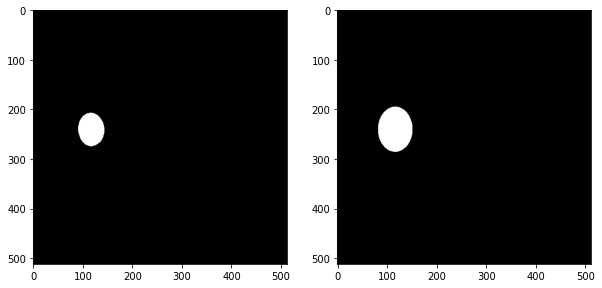

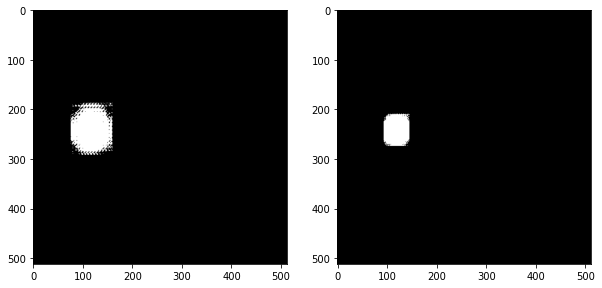

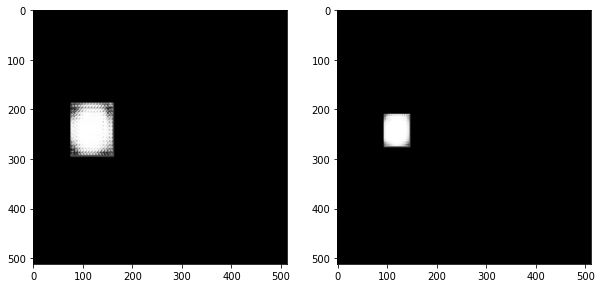

In [24]:
fig = plt.figure(figsize=(10,5))
for i in range(2):
  ax1 = fig.add_subplot(1,2,i+1)
  ax1.imshow(y[idx]['masks'].cpu()[i], 'gray')
plt.show()

fig = plt.figure(figsize=(10,5))
s = yhat[idx]['masks'].shape
for i in range(s[0]):
  ax1 = fig.add_subplot(1,s[0],i+1)
  ax1.imshow(thresh(yhat[idx]['masks'][i, 0].cpu().detach().numpy()), 'gray')
plt.show()

fig = plt.figure(figsize=(10,5))
for i in range(s[0]):
  ax1 = fig.add_subplot(1,s[0],i+1)
  ax1.imshow(yhat[idx]['masks'][i, 0].cpu().detach().numpy(), 'gray')
plt.show()